# BLU05  - Exercise Notebook 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import hashlib # for grading purposes

import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
warnings.filterwarnings("ignore") # specify to ignore warning messages
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

# Functions

In [2]:
def load_emissions_data():
    emissions = pd.read_csv('data/emissions.csv')
    emissions = emissions[emissions.Description=='Coal Electric Power Sector CO2 Emissions']
    emissions['YYYYMM'] = emissions['YYYYMM'].astype(str)
    emissions['YYYYMM'] = pd.to_datetime(emissions['YYYYMM'],format='%Y%m', errors='coerce').dropna()
    emissions = emissions.set_index('YYYYMM')
    emissions = emissions.sort_index()
    emissions['Value'] = emissions.Value.astype(float)
    emissions.index = emissions.index.rename('date')
    emissions = emissions['Value']
    emissions = emissions['1980':'2000']
    emissions = emissions.resample('MS').mean()
    return emissions

In [3]:
def load_coal_data():
    np.random.seed(10)
    df = pd.read_csv('data/MER_T06_01.csv')
    df = df[df.Description=='Coal Consumption']
    df.YYYYMM = pd.to_datetime(df.YYYYMM, format='%Y%m',errors='coerce' )
    df = df.set_index('YYYYMM')
    df = df.loc['1980':'2000']
    df.Value = pd.to_numeric(df.Value)
    df.Value = df.Value + np.random.normal(0,df.Value.mean()/20,len(df.Value))
    return df.Value.to_frame()

# Let's predict CO2 emissions!

In [4]:
emissions = load_emissions_data()

In [5]:
emissions_train = emissions[:'1997']
emissions_test = emissions['1997':]

##### Let's get an overview of the df and plot the series to get an idea of what's going on

In [6]:
emissions_train.head(13)

date
1980-01-01    100.568
1980-02-01     94.862
1980-03-01     93.210
1980-04-01     81.245
1980-05-01     82.785
1980-06-01     91.484
1980-07-01    107.126
1980-08-01    106.245
1980-09-01     95.662
1980-10-01     90.030
1980-11-01     91.239
1980-12-01    102.138
1981-01-01    108.164
Freq: MS, Name: Value, dtype: float64

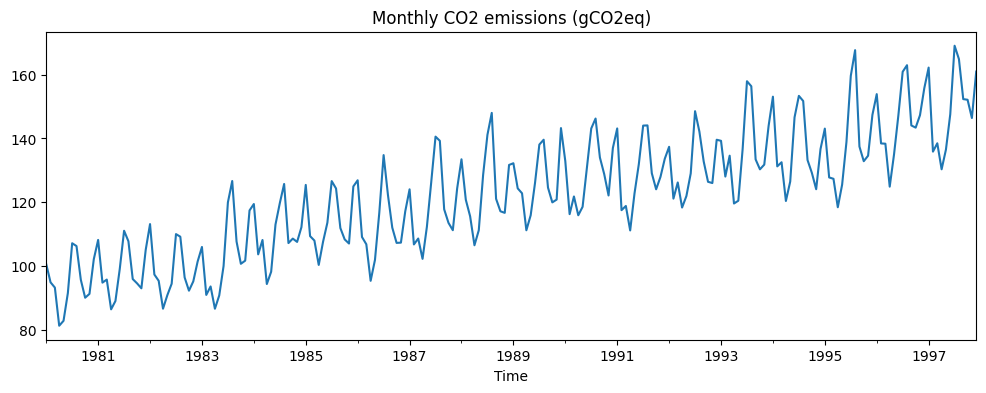

In [7]:
emissions_train.plot();
plt.xlabel('Time');
plt.title('Monthly CO2 emissions (gCO2eq)');

### Q1:Getting a feel of the data

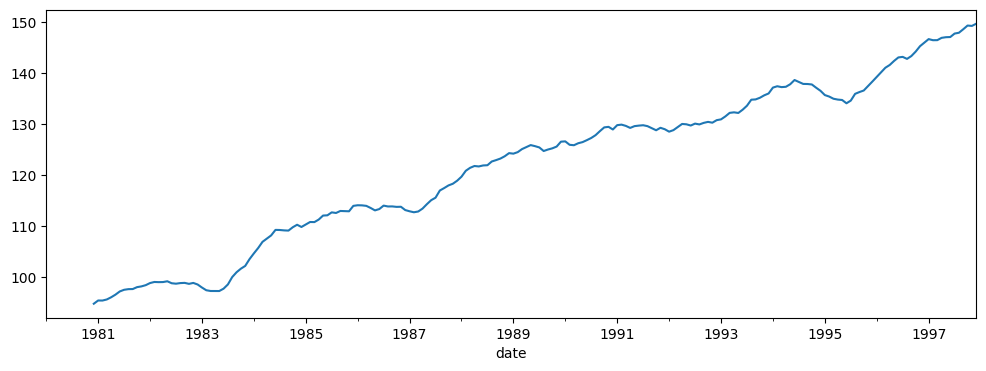

In [8]:
#To check the trend of dataset
emissions_train.rolling(12).mean().plot();

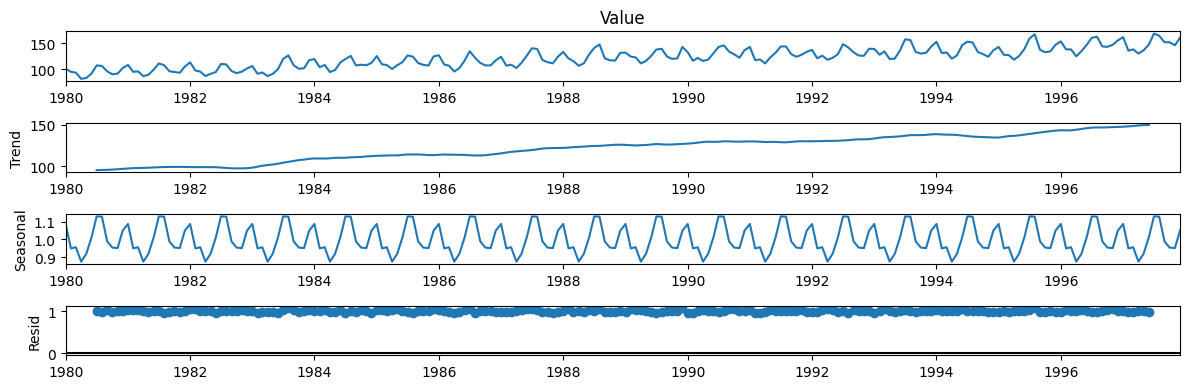

In [9]:
decomposition = seasonal_decompose(emissions_train, model='multiplicative')
decomposition.plot()
plt.show();

In [10]:
# Is the magnitude of the variance changing? answer with 'Yes' or 'No'
variance_change = "Yes"

# Does it have an apparent trend? answer with 'Yes' or 'No'
apparent_trend = "Yes"

# the emissions plot can give you some insights on these points.
# but we've also talked about clearer approaches like using some rolling ???? function
# and the seasonal_decompose function (extra tip: you can use a 1-year window, window=12)


In [11]:
expected_hash = '85a39ab345d672ff8ca9b9c6876f3adcacf45ee7c1e2dbd2408fd338bd55e07e'
assert hashlib.sha256(variance_change.encode()).hexdigest() == expected_hash
expected_hash = '85a39ab345d672ff8ca9b9c6876f3adcacf45ee7c1e2dbd2408fd338bd55e07e'
assert hashlib.sha256(apparent_trend.encode()).hexdigest() == expected_hash

### Q2: Make the time series stationary

In [12]:
emissions_train_log = emissions_train.map(np.log)
emissions_train_log_detrend = emissions_train_log.diff()
emissions_train_log_detrend_without_nans =  emissions_train_log_detrend.dropna()


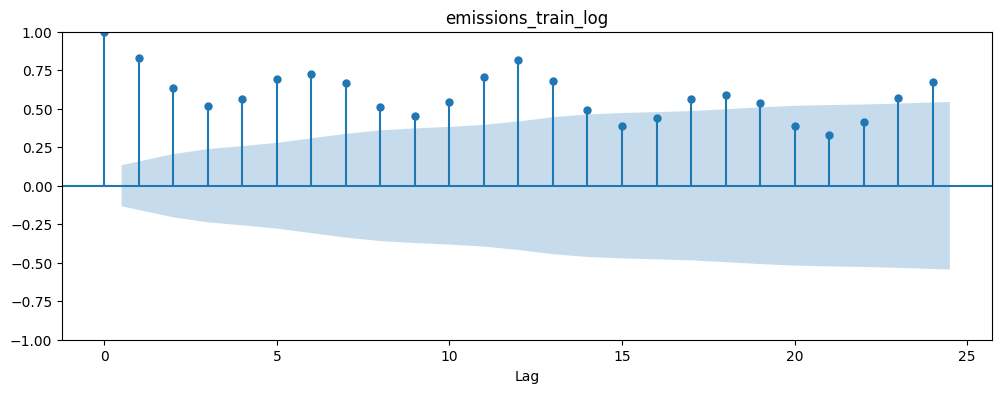

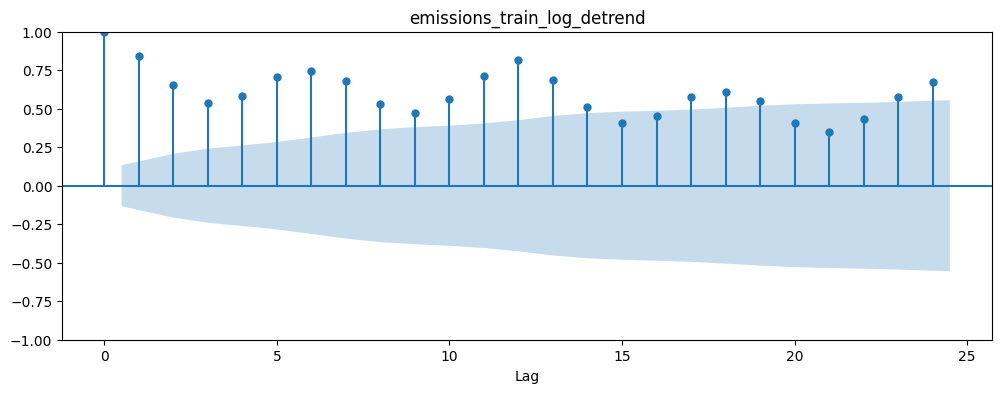

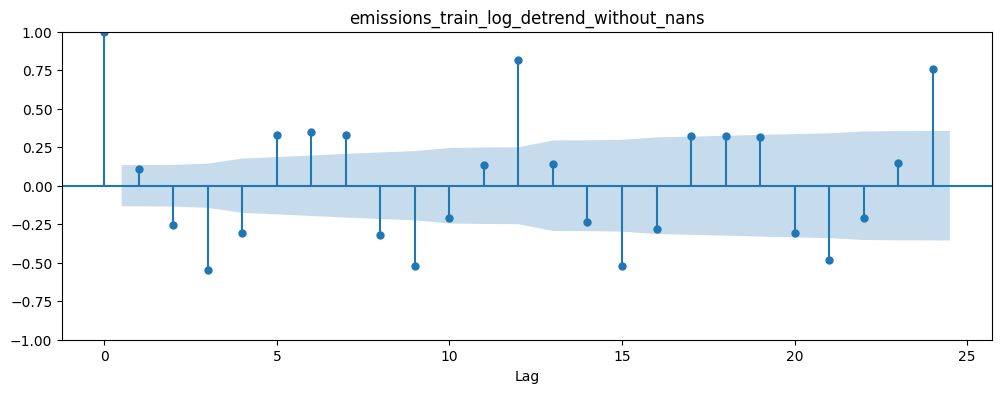

In [13]:
plot_acf(emissions_train);
plt.xlabel('Lag')
plt.title("emissions_train_log")
plot_acf(emissions_train_log);
plt.xlabel('Lag')
plt.title("emissions_train_log_detrend")
plot_acf(emissions_train_log_detrend_without_nans);
plt.xlabel('Lag')
plt.title("emissions_train_log_detrend_without_nans");

In [14]:
expected_hash = 'a9bd2829b2d2191c657f4e3b13bf0feca647eb3630a15ebac45aa578d6199e3d'
assert hashlib.sha256(str(np.round(emissions_train_log_detrend_without_nans[0],5)).encode()).hexdigest() == expected_hash

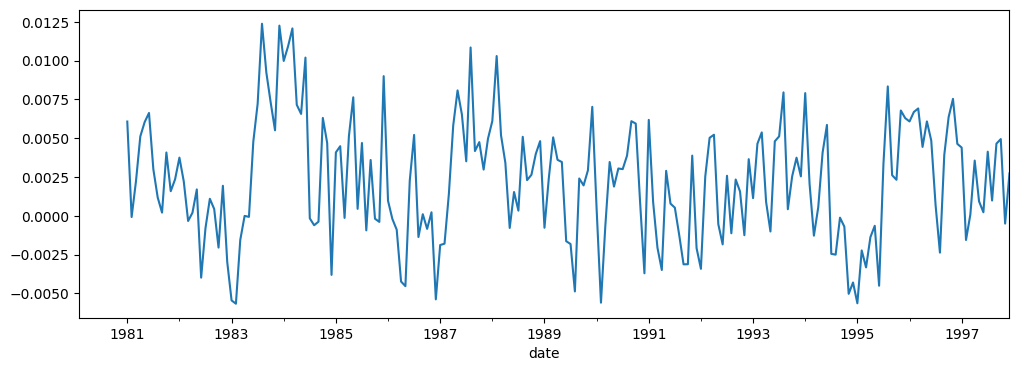

In [15]:
emissions_train_log_detrend_without_nans.rolling(12).mean().plot();

### Optional: Visualize the variance and/or trend of the stationarity timeseries

### Q3: Looking for seasonality

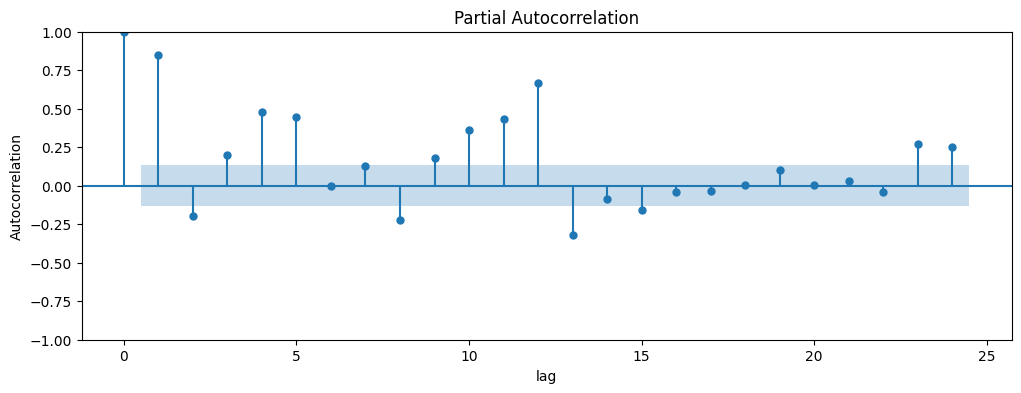

In [16]:
# Use the autocorrelation plots to infer what is the seasonality of the time series.

plot_pacf(emissions_train, alpha=0.05, lags=24, method='ols')
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

S = 12


In [17]:
assert isinstance(S, int)
expected_hash = '6b51d431df5d7f141cbececcf79edf3dd861c3b4069f0b11661a3eefacbba918'
assert hashlib.sha256(str(S).encode()).hexdigest() == expected_hash

### Q4: Fit a SARIMAX model on the train set using AutoARIMA

In [18]:
S

12

In [19]:
# Use S according to what you saw on the previous question.
# Use the logged train dataset, but not the diffed since pmdarima can find that on his own.
# Use the 'nm' method and maxiter=20
# Also define that warnings should be suppressed

sarimax = pm.AutoARIMA(trace=True, suppress_warnings=True, m=S, method='nm', maxiter=20)
sarimax.fit(emissions_train_log)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-707.438, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-434.184, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-693.262, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-558.916, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-436.049, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-605.235, Time=0.20 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-716.094, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-530.446, Time=0.08 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-726.150, Time=0.49 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-692.504, Time=0.51 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=-591.531, Time=0.39 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=-723.592, Time=0.49 sec
 ARIMA(3,1,2)(2,0,0)[12] intercept   : AIC=-707.411, Time=0.49 sec
 ARIMA(2,1,3)(2,0,0)[12] intercept   : AIC=-585.140, Time=0.50 sec
 ARIMA(1,1,1)(2,0,0

AutoARIMA(m=12, maxiter=20, method='nm', trace=True)

In [20]:
expected_hash = '5eed90f880c272ad2ae830b7d6c54f8362876cebc88c946db10dbf26aafa9a1b'
assert hashlib.sha256(str(sarimax.get_params()).encode()).hexdigest() == expected_hash

### Q5: Use that model to do the in-sample predictions and calculate the corresponding MSE

In [29]:
len(np.array(emissions_train_log))

216

In [25]:
# Don't forget that you used the logged dataset when training the model, thus its outputs will also be logged

predictions = np.array(sarimax.predict_in_sample())
mse = mean_squared_error(np.exp(predictions),np.exp(emissions_train_log))
predictions
mse

68.75216142214522

In [22]:
expected_hash = 'e84be574290605e678015094ff2db55a865d20754df25ef1fbbd86b9cc73a576'
assert hashlib.sha256(str(np.round(predictions,1)).encode()).hexdigest() == expected_hash

expected_hash = 'd4d63176def902021ddfc53b452cc750fcbec8e3e087976502ecf529ecaa2b8e'
assert hashlib.sha256(str(np.round(mse,1)).encode()).hexdigest() == expected_hash

AssertionError: 

### Q6: Forecast the test set using a multi-step forecast and calculate the corresponding MSE

In [ ]:
# Don't forget that you used the logged dataset when training the model.

# forecast = 
# mse = 

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
expected_hash = '433aed5fef7646ce383023e7fe95ebc0f4291a215cbb3d61fe3f3d307c06d3b4'
assert hashlib.sha256(str(np.round(forecast,1)).encode()).hexdigest() == expected_hash

expected_hash = '2185f687cc1bbae4025d1b867cd762892de64fac607059896b6bce8c62f62f34'
assert hashlib.sha256(str(np.round(mse,1)).encode()).hexdigest() == expected_hash

In [ ]:
emissions_test.plot()
pd.Series(forecast, index=emissions_test.index).plot()
plt.xlabel('Time')
plt.title('Monthly CO2 emissions (gCO2eq)')
plt.legend(['original','forecast'],loc=2)
print(mse)

### Q7: Forecast the test set using multiple one-step forecasts

### Q7.1: Get the rolling one-step forecasts

In [ ]:
# Don't forget to fit your sarimax model again
# You will need to make a for loop that updates the model

# sarimax_forecast_one_step_refit = []
# sarimax.fit(emissions_train_log)  
# emissions_test_logged = 
# Update loop

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
expected_hash = '7080152205ba48d591d1dede83e16a46e27f6d228a709220cb4e31d80a46adcc'
assert hashlib.sha256(str(np.round(sarimax_forecast_one_step_refit)).encode()).hexdigest() == expected_hash

### Q7.2: Calculate the corresponding MSE

In [ ]:
# Don't forget that you used the logged dataset when training the model.

# sarimax_forecast_one_step_refit_exp =
# mse =

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
expected_hash = 'bba8868023dbbbb0b719df3b375500c3a9643db09f8919a43a7774d578adc329'
assert hashlib.sha256(str(np.round(sarimax_forecast_one_step_refit_exp,1)).encode()).hexdigest() == expected_hash

expected_hash = 'cb30211d8e99f76a7f0b4f080b48cb2095f6b6128b07d52bbf030a78c146aea0'
assert hashlib.sha256(str(np.round(mse,1)).encode()).hexdigest() == expected_hash

In [ ]:
emissions_test.plot()
pd.Series(sarimax_forecast_one_step_refit_exp, index=emissions_test.index).plot()
plt.xlabel('Time')
plt.title('Monthly CO2 emissions (gCO2eq)')
plt.legend(['original','forecast'],loc=2)

print(mse)

### Q8: Repeat Q7 now with an exogenous input

Let's test the performance of our model using an exogenous input: the coal consumption. Note that the dataset below contains the coal consumption forecast made on the previous month. This means that we can use this exogenous data for doing one-step forecasts. 

In [ ]:
exog = load_coal_data()
exog_train = exog[:'1997']
exog_test = exog['1997':]

Let's look at the data to get an idea of what we can expect:

In [ ]:
exog_train.plot();
plt.xlabel('Time');
plt.title('Monthly coal consumption');

### Q8.1: Get the rolling one-step forecasts

In [ ]:
# Don't forget to fit your sarimax model again
# You will need to make a for loop that updates the model
# Note that this case is slightly different from the learning notebooks, where we used the exogenous data to do a
# multi-step forecast. Here we need to use the exogenous data in the context of multiple one-step forecasts, this 
# means we need to have an update loop where we also include the new values of the exogenous data 
# (similar to what was done in Q7.1).

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
expected_hash = 'acb1cf9da851c0c91595a3c6f68cc4669dbcb9d23dde524100b656376e1de214'
assert hashlib.sha256(str(np.round(sarimax_forecast_one_step_refit,1)).encode()).hexdigest() == expected_hash

### Q8.2: Calculate the corresponding MSE

In [ ]:
# Don't forget that you used the logged dataset when training the model.

# sarimax_forecast_one_step_refit_exp = 
# mse = 

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
expected_hash = 'ba39644cf33119587851eb252e85132508761fd8a8d708ca2e8e314754d8b9d9'
assert hashlib.sha256(str(np.round(sarimax_forecast_one_step_refit_exp,1)).encode()).hexdigest() == expected_hash

expected_hash = '0ac326686f62e06176321c58953c4eb0fed6c7610bdef09b71c7e8c36424daac'
assert hashlib.sha256(str(np.round(mse,1)).encode()).hexdigest() == expected_hash

In [ ]:
emissions_test.plot()
pd.Series(sarimax_forecast_one_step_refit_exp, index=emissions_test.index).plot()
plt.xlabel('Time')
plt.title('Monthly CO2 emissions (gCO2eq)')
plt.legend(['original','forecast'],loc=2)
print(mse)

### Q666: Unlock the power of the WMSE (optional)
So here's a little something which we didn't discuss in the Learning materials: _weighted_ metrics (be it MAE, MSE, etc.)

Now, let's dive in a trip of massive imagination:
- the CO2 emissions data set is respective to the _Island of Wonders_ 
- you are a travel agent selling holiday packs for this island (say what?!)
- every month you sell the same number of packs, except for August where your sales double (summer vacation!)
- all your clients are very picky about urban pollution and ask you for a month-ahead CO2 forecast

If you train/evaluate your model as usual, you get an all-rounder tool and an overall assessment. However, it might be of interest to take into account that there are 2x the clients in August and maybe give this month 2x the relevance.

For simplicity, we will leave the "training the model part" out (you can still explore this on your own). But take a look at the `sample_weight` parameter of `mean_squared_error` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)) and try to **calculate the test MSE using the same `sarimax_forecast_one_step_refit_exp` forecast but giving 2x the importance to the August records**.



In [ ]:
# create a baseline weight list filled with ones (1)
# w = 

# create a list with the month for each element of the test set
# month = 

# edit the w list, giving the August elements double the weight
# ...

# calculate the WMAE
# wmse_august_double_relevance = 

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
expected_hash = '0ac326686f62e06176321c58953c4eb0fed6c7610bdef09b71c7e8c36424daac'
assert hashlib.sha256(str(np.round(mse,1)).encode()).hexdigest() == expected_hash

In [ ]:
print(mse)
print(wmse_august_double_relevance)